In [454]:
import pandas as pd
import numpy as np

In [455]:
care_df=pd.read_csv("./test/care.csv")

In [456]:
diagnosis_df=pd.read_csv("./test/diagnosis.csv")

In [457]:
patient_df=pd.read_csv("./test/patient.csv")

In [458]:
visit_df=pd.read_csv("./test/visit.csv")

In [459]:
combined_df = care_df.merge(diagnosis_df, on='patient_id', how='inner') \
                 .merge(patient_df, on='patient_id', how='inner') \
                 .merge(visit_df, on='patient_id', how='inner')


In [460]:
risk_df=pd.read_csv("./train/risk.csv")

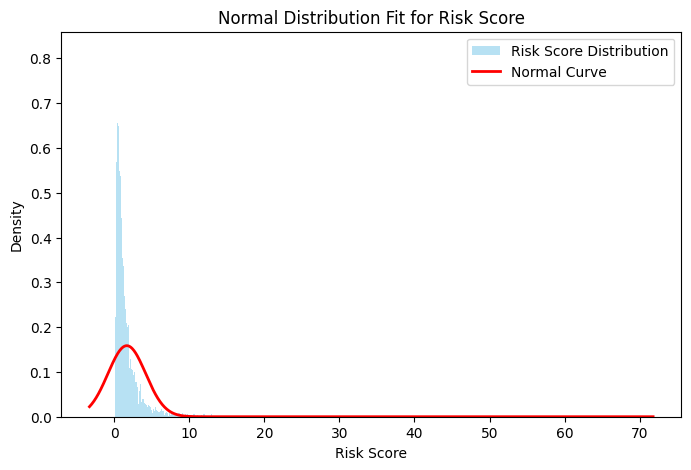

In [461]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Drop NaN values from risk_score if any
data = risk_df['risk_score'].dropna()

# Compute mean and standard deviation
mu, std = data.mean(), data.std()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(data, bins=1000, density=True, alpha=0.6, color='skyblue', label='Risk Score Distribution')

# Plot normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Curve')

# Labels
plt.title('Normal Distribution Fit for Risk Score')
plt.xlabel('Risk Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [462]:
merged_df = pd.merge(diagnosis_df, risk_df, on='patient_id', how='inner')

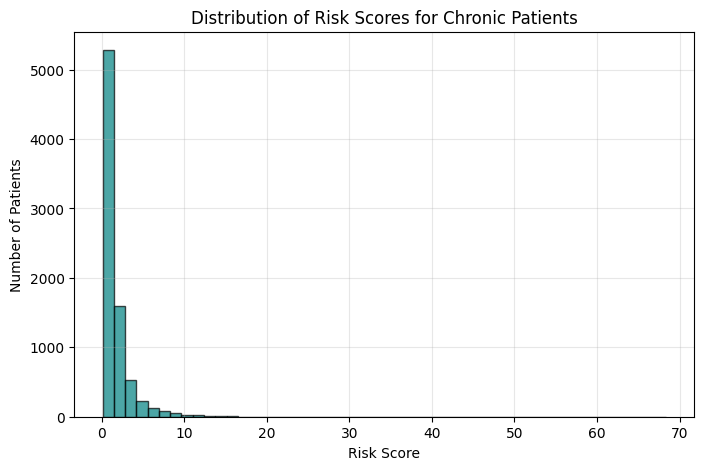

In [463]:
import matplotlib.pyplot as plt

# Assuming you already have chronic_risk_scores from earlier
plt.figure(figsize=(8,5))
plt.hist(risk_df['risk_score'], bins=50, color='teal', alpha=0.7, edgecolor='black')

# Labels and title
plt.title('Distribution of Risk Scores for Chronic Patients')
plt.xlabel('Risk Score')
plt.ylabel('Number of Patients')
plt.grid(alpha=0.3)
plt.show()


In [464]:
from scipy import stats
z = np.abs(stats.zscore(risk_df['risk_score']))
risk_df[z > 3]


,patient_id,risk_score
2,310,11.70
116,1536,16.43
130,1683,15.92
148,1810,13.79
182,2161,13.55
...,...,...
7555,78165,12.65
7817,80315,9.72
7820,80345,10.26
7827,80668,9.29


In [465]:
care_df['care_count_per_patient'] = care_df.groupby('patient_id')['care_id'].transform('count')


In [466]:
care_df_new=care_df.drop('care_id',axis=1)

In [467]:
care_df_new=care_df.drop(['last_care_dt','next_care_dt'],axis=1)

In [468]:
care_df_new=care_df_new.drop('care_id',axis=1)

In [469]:
# Filter only LAB_TEST rows
lab_test_df = care_df_new[care_df_new['msrmnt_type'] == 'LAB TEST']

# Get all unique subtypes
subtypes = lab_test_df['msrmnt_sub_type'].unique()

# Create a column for each LAB_TEST subtype (1 if that subtype exists for the patient, else 0)
for subtype in subtypes:
    care_df_new[f'LAB_TEST_{subtype}'] = care_df_new.apply(
        lambda x: x['msrmnt_value'] if (x['msrmnt_type'] == 'LAB TEST' and x['msrmnt_sub_type'] == subtype) else 0,
        axis=1
    )
care_df_new

,patient_id,msrmnt_type,msrmnt_sub_type,msrmnt_value,care_gap_ind,care_count_per_patient,LAB_TEST_SYSTOLIC BLOOD PRESSURE,LAB_TEST_HbA1c,LAB_TEST_DIASTOLIC BLOOD PRESSURE
0,385,SCREENING,BREAST CANCER,0.0,t,1,0.0,0.0,0.0
1,804,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
2,1200,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
3,1300,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
4,3892,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
102,75411,SCREENING,BREAST CANCER,0.0,t,2,0.0,0.0,0.0
103,75411,SCREENING,COLORECTAL CANCER,0.0,t,2,0.0,0.0,0.0
104,76458,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0
105,76638,SCREENING,COLORECTAL CANCER,0.0,t,1,0.0,0.0,0.0


In [470]:
# Separate LAB TEST rows
lab_test_rows = care_df_new[care_df_new['msrmnt_type'] == 'LAB TEST']

# Keep only non-lab rows for encoding
non_lab_rows = care_df_new[care_df_new['msrmnt_type'] != 'LAB TEST']

# Perform one-hot encoding on non-lab rows
encoded_df = pd.get_dummies(non_lab_rows, columns=['msrmnt_sub_type'], prefix='SUBTYPE')

# Combine back with LAB TEST rows
care_df_new = pd.concat([encoded_df, lab_test_rows], ignore_index=True)


In [471]:
care_df_new = care_df_new.drop(columns=['msrmnt_sub_type','msrmnt_type','msrmnt_value'])


In [472]:
cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]

care_df_new[cols] = care_df_new[cols].fillna(False)


/tmp/ipykernel_28417/3862260571.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  care_df_new[cols] = care_df_new[cols].fillna(False)


In [473]:
diagnosis_df['diagnosis_count_per_patient'] = diagnosis_df.groupby('patient_id')['diagnosis_id'].transform('count')

In [474]:
diagnosis_df = pd.get_dummies(diagnosis_df, columns=['condition_name'], prefix='COND')


In [475]:
diagnosis_df_new=diagnosis_df.drop(['diagnosis_id','condition_type','condition_description','is_chronic'],axis=1)

In [476]:
visit_counts = (
    visit_df
    .groupby(['patient_id', 'visit_type'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('VISIT_')
    .reset_index()
)


In [477]:
visit_counts

visit_type,patient_id,VISIT_ER,VISIT_INPATIENT,VISIT_URGENT CARE
0,95,1,0,1
1,168,1,0,0
2,309,0,0,1
3,333,1,1,0
4,344,1,0,0
...,...,...,...,...
762,81531,1,0,0
763,81844,5,0,0
764,81925,1,0,1
765,82069,1,0,0


In [478]:
# 1️⃣ Convert to datetime
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'])

# 2️⃣ Calculate number of days per visit
visit_df['visit_days'] = (visit_df['visit_end_dt'] - visit_df['visit_start_dt']).dt.days + 1

# 3️⃣ Get number of visits per patient per type
visit_counts = (
    visit_df
    .groupby(['patient_id', 'visit_type'])
    .size()
    .unstack(fill_value=0)
    .add_prefix('VISIT_COUNT_')
)

# 4️⃣ Get total days per patient per type
visit_days = (
    visit_df
    .groupby(['patient_id', 'visit_type'])['visit_days']
    .sum()
    .unstack(fill_value=0)
    .add_prefix('VISIT_DAYS_')
)

# 5️⃣ Merge both together
visit_summary = (
    visit_counts
    .merge(visit_days, left_index=True, right_index=True)
    .reset_index()
)


In [479]:
patient_conditions = (
    diagnosis_df_new.groupby('patient_id')[['COND_CANCER', 'COND_DIABETES', 'COND_HYPERTENSION']]
    .max()
    .assign(total_conditions=lambda x: x.sum(axis=1))
    .reset_index()
)


In [480]:
diagnosis_df_new=patient_conditions.drop('total_conditions',axis=1)

In [481]:
diagnosis_df_new = diagnosis_df_new.astype(int)


In [482]:
subtype_cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]


In [483]:
care_visits_per_patient = (
    care_df_new
    .groupby('patient_id')[subtype_cols]
    .sum()
    .reset_index()
)


In [484]:
lab_test_cols = [
    'LAB_TEST_HbA1c',
    'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
    'LAB_TEST_DIASTOLIC BLOOD PRESSURE'
]

lab_test_avg = (
    care_df_new
    .groupby('patient_id')[lab_test_cols]
    .mean()
    .reset_index()
)


In [485]:
merged_df_care = pd.merge(care_visits_per_patient, lab_test_avg, on='patient_id', how='outer')


In [486]:
# Define columns
lab_test_cols = [
    'LAB_TEST_HbA1c',
    'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
    'LAB_TEST_DIASTOLIC BLOOD PRESSURE'
]

subtype_cols = [
    'SUBTYPE_BREAST CANCER',
    'SUBTYPE_CHOLESTEROL',
    'SUBTYPE_COLORECTAL CANCER',
    'SUBTYPE_DIABETES',
    'SUBTYPE_HYPERTENSION'
]

# Create aggregation dictionary
agg_dict = {col: 'mean' for col in lab_test_cols}  # average lab tests
agg_dict.update({col: 'sum' for col in subtype_cols})  # sum subtype visits
agg_dict.update({'care_gap_ind': 'first', 'care_count_per_patient': 'first'})  # other columns

# Aggregate per patient
patient_summary = care_df_new.groupby('patient_id').agg(agg_dict).reset_index()


In [487]:
care_df_new=patient_summary.drop(['care_count_per_patient'],axis=1)

In [488]:
care_df_new['care_gap_ind'] = care_df_new['care_gap_ind'].map({'t': 1, 'f': 0})


In [489]:
cols_to_drop = [col for col in patient_df.columns if 'hot_spotter' in col]
patient_df_new = patient_df.drop(columns=cols_to_drop)


In [490]:
from functools import reduce

# List of your 4 dataframes
dfs = [care_df_new, diagnosis_df_new, patient_df_new, visit_summary]  # replace with your actual dataframe names

# Merge all dataframes on 'patient_id' using outer join
merged_df = reduce(lambda left, right: pd.merge(left, right, on='patient_id', how='outer'), dfs)

# Fill missing values with 0
merged_df = merged_df.fillna(0)


In [491]:
# Merge risk_df with merged_df on patient_id
final_df = pd.merge(merged_df, risk_df[['patient_id', 'risk_score']], on='patient_id', how='left')

# Optional: fill missing risk_score with 0 if some patients don't have a risk value
final_df['risk_score'] = final_df['risk_score'].fillna(0)


In [492]:
%pip install xgboost

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [493]:
# Add a small constant to avoid log(0)
final_df['log_risk_score'] = np.log1p(final_df['risk_score'])


In [494]:
# Features
X = final_df.drop(columns=['patient_id', 'risk_score', 'log_risk_score'])
# Target (log-transformed)
y = final_df['log_risk_score']


In [495]:
import pandas as pd

# Ensure datetime
care_df['last_care_dt'] = pd.to_datetime(care_df['last_care_dt'])
care_df['next_care_dt'] = pd.to_datetime(care_df['next_care_dt'])

# Gap in days where both dates exist
care_df['care_gap_days'] = (care_df['next_care_dt'] - care_df['last_care_dt']).dt.days

# Indicator for having next care scheduled
care_df['has_next_care'] = care_df['next_care_dt'].notna().astype(int)

In [496]:
# Define 6-month period starting from the earliest date
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
first_visit = visit_df.groupby('patient_id')['visit_start_dt'].min().reset_index()
first_visit = first_visit.rename(columns={'visit_start_dt': 'first_visit_dt'})
visit_df = visit_df.merge(first_visit, on='patient_id', how='left')
# 182 days ≈ 6 months
visit_df['period_6m'] = ((visit_df['visit_start_dt'] - visit_df['first_visit_dt']).dt.days // 182).astype(int)
freq_df = (
    visit_df
    .groupby(['patient_id', 'period_6m'])
    .size()
    .reset_index(name='visit_count')
)



In [497]:
# Pivot so each period becomes a column
freq_pivot = freq_df.pivot(index='patient_id', columns='period_6m', values='visit_count').fillna(0)

# Rename columns to meaningful names
freq_pivot.columns = [f'visit_count_6m_{col}' for col in freq_pivot.columns]

# Reset index to make patient_id a column
freq_pivot = freq_pivot.reset_index()


In [498]:

visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])

# Step 1: Get first visit per patient
first_visit = visit_df.groupby('patient_id')['visit_start_dt'].min().reset_index()
first_visit = first_visit.rename(columns={'visit_start_dt': 'first_visit_dt'})


In [502]:

# Step 2: Merge first visit back
visit_df = visit_df.merge(first_visit, on='patient_id', how='left')

# Step 3: Compute 6-month period per patient
visit_df['period_6m'] = ((visit_df['visit_start_dt'] - visit_df['first_visit_dt']).dt.days // 182).astype(int)

# Step 4: Count visits per patient per 6-month period
freq_df = (
    visit_df
    .groupby(['patient_id', 'period_6m'])
    .size()
    .reset_index(name='visit_count')
)

# Step 5: Pivot so each period becomes a column
freq_pivot = freq_df.pivot(index='patient_id', columns='period_6m', values='visit_count').fillna(0)
freq_pivot.columns = [f'visit_count_6m_{col}' for col in freq_pivot.columns]
freq_pivot = freq_pivot.reset_index()

# Step 6: Add total visit counts per patient
total_visits = visit_df.groupby('patient_id').size().reset_index(name='total_visit_count')

# Merge total visits with the pivoted dataframe
patient_visit_features = freq_pivot.merge(total_visits, on='patient_id', how='left')

# Result: one row per patient, visit counts per 6-month period + total visits
print(patient_visit_features.head())


   patient_id  visit_count_6m_0  visit_count_6m_1  visit_count_6m_2  \
0          95               2.0               0.0               0.0   
1         168               1.0               0.0               0.0   
2         309               1.0               0.0               0.0   
3         333               2.0               0.0               0.0   
4         344               1.0               0.0               0.0   

   visit_count_6m_3  total_visit_count  
0               0.0                  2  
1               0.0                  1  
2               0.0                  1  
3               0.0                  2  
4               0.0                  1  


In [503]:
import pandas as pd

# Ensure datetime
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])

# Sort visits per patient
visit_df = visit_df.sort_values(by=['patient_id', 'visit_start_dt'])

# Compute gap between consecutive visits per patient
visit_df['prev_visit'] = visit_df.groupby('patient_id')['visit_start_dt'].shift(1)
visit_df['gap_days'] = (visit_df['visit_start_dt'] - visit_df['prev_visit']).dt.days

# Calculate average gap per patient
avg_gap = visit_df.groupby('patient_id')['gap_days'].mean().reset_index()
avg_gap = avg_gap.rename(columns={'gap_days': 'avg_visit_gap_days'})

# Fill NaN gaps (first visit) with 0 or leave as NaN if you prefer
avg_gap['avg_visit_gap_days'] = avg_gap['avg_visit_gap_days'].fillna(0)

print(avg_gap)


     patient_id  avg_visit_gap_days
0            95               37.00
1           168                0.00
2           309                0.00
3           333                1.00
4           344                0.00
..          ...                 ...
762       81531                0.00
763       81844              149.25
764       81925              188.00
765       82069                0.00
766       82163                6.00

[767 rows x 2 columns]


In [504]:
# Merge patient-level visit counts with final_df
final_df = final_df.merge(patient_visit_features, on='patient_id', how='left')

# Merge average visit gap per patient
final_df = final_df.merge(avg_gap, on='patient_id', how='left')

# Optional: fill any remaining NaN values with 0
final_df.fillna(0, inplace=True)

# Check result
print(final_df.head())


   patient_id  LAB_TEST_HbA1c  LAB_TEST_SYSTOLIC BLOOD PRESSURE  \
0          95             0.0                               0.0   
1         168             0.0                               0.0   
2         249             0.0                               0.0   
3         253             0.0                               0.0   
4         276             0.0                               0.0   

   LAB_TEST_DIASTOLIC BLOOD PRESSURE  SUBTYPE_BREAST CANCER  \
0                                0.0                    0.0   
1                                0.0                    0.0   
2                                0.0                    0.0   
3                                0.0                    0.0   
4                                0.0                    0.0   

   SUBTYPE_CHOLESTEROL  SUBTYPE_COLORECTAL CANCER  SUBTYPE_DIABETES  \
0                  0.0                        0.0               0.0   
1                  0.0                        0.0               0.0   
2    

In [515]:
final_df['LAB_TEST_HbA1c'] = final_df['LAB_TEST_HbA1c'].replace(0, 5.7)


In [516]:
final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].replace(0, 120)

In [517]:
final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] = final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].replace(5.7, 80)

In [518]:
import pandas as pd

# Ensure date columns are in datetime format
visit_df['visit_start_dt'] = pd.to_datetime(visit_df['visit_start_dt'])
visit_df['visit_end_dt'] = pd.to_datetime(visit_df['visit_end_dt'])
# visit_df['follow_up_dt'] = pd.to_datetime(visit_df['follow_up_dt'])

# Sort by patient and visit start date
visit_df = visit_df.sort_values(['patient_id', 'visit_start_dt'])

# Calculate day gaps between consecutive visits for each patient
visit_df['prev_visit_start'] = visit_df.groupby('patient_id')['visit_start_dt'].shift(1)
visit_df['day_gap'] = (visit_df['visit_start_dt'] - visit_df['prev_visit_start']).dt.days

# Calculate average day gap for each patient
avg_gap = visit_df.groupby('patient_id')['day_gap'].mean().reset_index()
avg_gap.rename(columns={'day_gap':'avg_day_gap'}, inplace=True)

print(avg_gap)


     patient_id  avg_day_gap
0            95        37.00
1           168          NaN
2           309          NaN
3           333         1.00
4           344          NaN
..          ...          ...
762       81531          NaN
763       81844       149.25
764       81925       188.00
765       82069          NaN
766       82163         6.00

[767 rows x 2 columns]


In [519]:
# Ensure date columns are datetime if needed (optional, if using visit gaps)
# final_df['visit_start_dt'] = pd.to_datetime(final_df['visit_start_dt'])
# final_df['visit_end_dt'] = pd.to_datetime(final_df['visit_end_dt'])

# 1. Total visits and total visit days
final_df['total_visits'] = final_df['VISIT_COUNT_ER'] + final_df['VISIT_COUNT_INPATIENT'] + final_df['VISIT_COUNT_URGENT CARE']
final_df['total_visit_days'] = final_df['VISIT_DAYS_ER'] + final_df['VISIT_DAYS_INPATIENT'] + final_df['VISIT_DAYS_URGENT CARE']

# 2. Average days per visit
final_df['avg_days_per_visit'] = final_df['total_visit_days'] / final_df['total_visits'].replace(0,1)

# 3. Ratios of visit types
final_df['ER_to_total_visits'] = final_df['VISIT_COUNT_ER'] / final_df['total_visits'].replace(0,1)
final_df['Inpatient_to_total_visits'] = final_df['VISIT_COUNT_INPATIENT'] / final_df['total_visits'].replace(0,1)

# 4. Average days per visit type
final_df['avg_days_ER'] = final_df['VISIT_DAYS_ER'] / final_df['VISIT_COUNT_ER'].replace(0,1)
final_df['avg_days_inpatient'] = final_df['VISIT_DAYS_INPATIENT'] / final_df['VISIT_COUNT_INPATIENT'].replace(0,1)
final_df['avg_days_urgent'] = final_df['VISIT_DAYS_URGENT CARE'] / final_df['VISIT_COUNT_URGENT CARE'].replace(0,1)

# 5. Blood pressure ratio
final_df['BP_ratio'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] / final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].replace(0,1)

# 6. Number of comorbidities
final_df['num_conditions'] = final_df[['COND_CANCER','COND_DIABETES','COND_HYPERTENSION']].sum(axis=1)

# 7. Age group (bins)
final_df['age_group'] = pd.cut(final_df['age'], bins=[0,30,45,60,75,100], labels=[1,2,3,4,5])

# 8. Interaction: age × diabetes
final_df['age_times_diabetes'] = final_df['age'] * final_df['COND_DIABETES']

# 9. High utilizer flag
final_df['high_utilizer'] = (final_df['total_visits'] > final_df['total_visits'].median()).astype(int)

# 10. Risk tier (quartiles)
# final_df['risk_tier'] = pd.qcut(final_df['risk_score'], 4, labels=False)


In [520]:
import numpy as np
import pandas as pd

# -------------------------
# 1. Average gap between visits per patient (if visit_start_dt available)
# -------------------------
if 'visit_start_dt' in final_df.columns:
    final_df['visit_start_dt'] = pd.to_datetime(final_df['visit_start_dt'])
    final_df = final_df.sort_values(['patient_id', 'visit_start_dt'])
    final_df['prev_visit'] = final_df.groupby('patient_id')['visit_start_dt'].shift(1)
    final_df['day_gap'] = (final_df['visit_start_dt'] - final_df['prev_visit']).dt.days
    avg_gap = final_df.groupby('patient_id')['day_gap'].mean().reset_index()
    avg_gap.rename(columns={'day_gap':'avg_day_gap'}, inplace=True)
    final_df = final_df.merge(avg_gap, on='patient_id', how='left')

# -------------------------
# 2. Age × number of conditions
# -------------------------
final_df['age_times_num_conditions'] = final_df['age'] * final_df['num_conditions']

# -------------------------
# 3. HbA1c × diabetes
# -------------------------
final_df['HbA1c_times_diabetes'] = final_df['LAB_TEST_HbA1c'] * final_df['COND_DIABETES']

# -------------------------
# 4. Systolic – diastolic BP difference
# -------------------------
final_df['BP_diff'] = final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] - final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE']

# -------------------------
# 5. Binary lab flags
# -------------------------
final_df['high_HbA1c'] = (final_df['LAB_TEST_HbA1c'] > 5.7).astype(int)
final_df['high_BP'] = ((final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] > 130) |
                       (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] > 80)).astype(int)

# -------------------------
# 6. Proportion of long visits (ER days > 1)
# -------------------------
final_df['long_ER_ratio'] = (final_df['VISIT_DAYS_ER'] > 1).astype(int) / final_df['total_visits'].replace(0,1)

# -------------------------
# 7. Weighted visit days
# -------------------------
final_df['weighted_visit_days'] = (final_df['VISIT_DAYS_ER']*1 +
                                   final_df['VISIT_DAYS_INPATIENT']*2 +
                                   final_df['VISIT_DAYS_URGENT CARE']*1.5)

# -------------------------
# 8. Visit type diversity
# -------------------------
final_df['visit_type_diversity'] = ((final_df['VISIT_COUNT_ER']>0).astype(int) +
                                   (final_df['VISIT_COUNT_INPATIENT']>0).astype(int) +
                                   (final_df['VISIT_COUNT_URGENT CARE']>0).astype(int))



# -------------------------
# 11. Care gap × number of conditions
# -------------------------
final_df['caregap_times_conditions'] = final_df['care_gap_ind'] * final_df['num_conditions']

# -------------------------
# 12. Lab bins (categorical)
# -------------------------
final_df['HbA1c_bin'] = pd.cut(final_df['LAB_TEST_HbA1c'], bins=[0,5.7,6.5,10], labels=[0,1,2])
final_df['BP_bin'] = pd.cut(final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'], bins=[0,120,140,200], labels=[0,1,2])


In [521]:
import numpy as np
import pandas as pd

# Assuming 'final_df' is your DataFrame

# -----------------------------------------------------------------
# 1. Warning: Check for Target Leakage
# -----------------------------------------------------------------
# If 'risk_tier' was created FROM 'risk_score' or 'log_risk_score',
# it MUST be removed before training.
# Uncomment the line below if this is the case.
#
# if 'risk_tier' in final_df.columns:
#     final_df = final_df.drop(columns=['risk_tier'])
#     print("Dropped 'risk_tier' to prevent target leakage.")


# -----------------------------------------------------------------
# 2. Comorbidity and Interaction Features
# -----------------------------------------------------------------
print("Creating Comorbidity and Interaction features...")

# Specific Comorbidities
final_df['diabetes_and_hypertension'] = final_df['COND_DIABETES'] * final_df['COND_HYPERTENSION']
final_df['diabetes_and_cancer'] = final_df['COND_DIABETES'] * final_df['COND_CANCER']
final_df['cancer_and_hypertension'] = final_df['COND_CANCER'] * final_df['COND_HYPERTENSION']
final_df['triple_threat'] = final_df['COND_DIABETES'] * final_df['COND_HYPERTENSION'] * final_df['COND_CANCER']

# Condition + Lab Value Interactions
final_df['hypertension_and_high_BP'] = final_df['COND_HYPERTENSION'] * final_df['high_BP']
final_df['hypertension_and_BP_diff'] = final_df['COND_HYPERTENSION'] * final_df['BP_diff']

# Care Gap Interactions
final_df['caregap_and_high_HbA1c'] = final_df['care_gap_ind'] * final_df['high_HbA1c']
final_df['caregap_and_high_utilizer'] = final_df['care_gap_ind'] * final_df['high_utilizer']
final_df['caregap_and_diabetes'] = final_df['care_gap_ind'] * final_df['COND_DIABETES']

# Age + Utilization Interaction
final_df['age_and_ER_visits'] = final_df['age'] * final_df['VISIT_COUNT_ER']


# -----------------------------------------------------------------
# 3. Clinical & Lab-Based Features
# -----------------------------------------------------------------
print("Creating Clinical & Lab-Based features...")

# Mean Arterial Pressure (MAP)
final_df['MAP'] = (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] + 2 * final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE']) / 3


# [Image of Mean Arterial Pressure calculation formula]


# BP Categories (Categorical Feature)
# Using np.select for efficient binning
bp_conditions = [
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] < 120) & (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] < 80),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].between(120, 129)) & (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] < 80),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'].between(130, 139)) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'].between(80, 89)),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] >= 140) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] >= 90),
    (final_df['LAB_TEST_SYSTOLIC BLOOD PRESSURE'] > 180) | (final_df['LAB_TEST_DIASTOLIC BLOOD PRESSURE'] > 120)
]
bp_choices = [
    1, # Normal
    2, # Elevated
    3, # Stage 1 HTN
    4, # Stage 2 HTN
    5  # Hypertensive Crisis
]
# default=0 to catch any NaNs or edge cases
final_df['BP_category'] = np.select(bp_conditions, bp_choices, default=0)


# [Image of Blood Pressure Categories Chart]


# HbA1c Categories (Categorical Feature)
hba1c_conditions = [
    (final_df['LAB_TEST_HbA1c'] < 5.7),
    (final_df['LAB_TEST_HbA1c'].between(5.7, 6.4)),
    (final_df['LAB_TEST_HbA1c'].between(6.5, 8.0)),
    (final_df['LAB_TEST_HbA1c'] > 8.0)
]
hba1c_choices = [
    1, # Normal
    2, # Prediabetes
    3, # Controlled Diabetes
    4  # Uncontrolled Diabetes
]
# default=0 to catch any NaNs
final_df['HbA1c_category'] = np.select(hba1c_conditions, hba1c_choices, default=0)


# -----------------------------------------------------------------
# 4. Trend & Recency Features (from visit_count_6m_...)
# -----------------------------------------------------------------
print("Creating Trend & Recency features...")

# List of the 6-month visit columns in order (oldest to newest)
# Adjust this list if your column names or order are different
visit_cols = [
    'visit_count_6m_0', 'visit_count_6m_1', 'visit_count_6m_2',
    'visit_count_6m_3', 'visit_count_6m_4'
]

# Ensure these columns exist before proceeding
if all(col in final_df.columns for col in visit_cols):
    # Visit Trend (Slope)
    # We use np.polyfit to find the slope of the line of best fit
    periods = np.arange(len(visit_cols))

    # Define a function to apply to each row
    def get_slope(row):
        # We need at least 2 non-NaN points to fit a line
        if row.notna().sum() < 2:
            return np.nan
        # Fit a 1-degree polynomial (a line) and return the slope (the first coefficient)
        # We use .dropna() to handle any missing periods
        valid_indices = row.notna()
        return np.polyfit(periods[valid_indices], row[valid_indices], 1)[0]

    # Use .apply() along axis=1 (rows)
    final_df['visit_trend_slope'] = final_df[visit_cols].apply(get_slope, axis=1)

    # Recent vs. Past Utilization (assuming _3 and _4 are most recent)
    final_df['recent_visits'] = final_df['visit_count_6m_3'] + final_df['visit_count_6m_4']
    final_df['past_visits'] = final_df['visit_count_6m_0'] + final_df['visit_count_6m_1']
    final_df['recent_vs_past_diff'] = final_df['recent_visits'] - final_df['past_visits']

    # Visit Volatility (Standard Deviation of visits)
    final_df['visit_volatility'] = final_df[visit_cols].std(axis=1)

    # Zero-Visit Periods
    final_df['zero_visit_periods_count'] = (final_df[visit_cols] == 0).sum(axis=1)
else:
    print("Warning: Not all 'visit_count_6m_...' columns were found. Skipping Trend features.")


# -----------------------------------------------------------------
# 5. Advanced Utilization Ratios
# -----------------------------------------------------------------
print("Creating Advanced Utilization Ratios...")

# Add a small epsilon to denominators to prevent division by zero
epsilon = 1e-6

# High-Acuity Visit Ratio
final_df['high_acuity_visits'] = final_df['VISIT_COUNT_ER'] + final_df['VISIT_COUNT_INPATIENT']
final_df['high_acuity_ratio'] = final_df['high_acuity_visits'] / (final_df['total_visit_count'] + epsilon)

# High-Acuity Days Ratio
final_df['high_acuity_days'] = final_df['VISIT_DAYS_ER'] + final_df['VISIT_DAYS_INPATIENT']
final_df['high_acuity_days_ratio'] = final_df['high_acuity_days'] / (final_df['total_visit_days'] + epsilon)

# Urgent Care Ratio
final_df['urgent_care_ratio'] = final_df['VISIT_COUNT_URGENT CARE'] / (final_df['total_visit_count'] + epsilon)


print("\nFeature creation complete.")
print(f"New features added: {list(final_df.columns[-18:])}") # Show the last 18 new columns

Creating Comorbidity and Interaction features...
Creating Clinical & Lab-Based features...
Creating Trend & Recency features...
Creating Advanced Utilization Ratios...


KeyError: 'total_visit_count'

/tmp/ipykernel_28417/2224888280.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 20:
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipykernel_28417/2224888280.py:36: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):
/tmp/ipyker

Identified 59 discrete features.
Calculating Mutual Information scores...

--- Mutual Information Scores (Feature vs. Target) ---
VISIT_DAYS_INPATIENT         0.028539
total_visit_days             0.010246
age                          0.009552
avg_days_per_visit           0.005561
caregap_and_diabetes         0.004670
                               ...   
cancer_and_hypertension      0.000000
age_and_ER_visits            0.000000
caregap_and_high_utilizer    0.000000
caregap_and_high_HbA1c       0.000000
high_acuity_visits           0.000000
Length: 70, dtype: float64


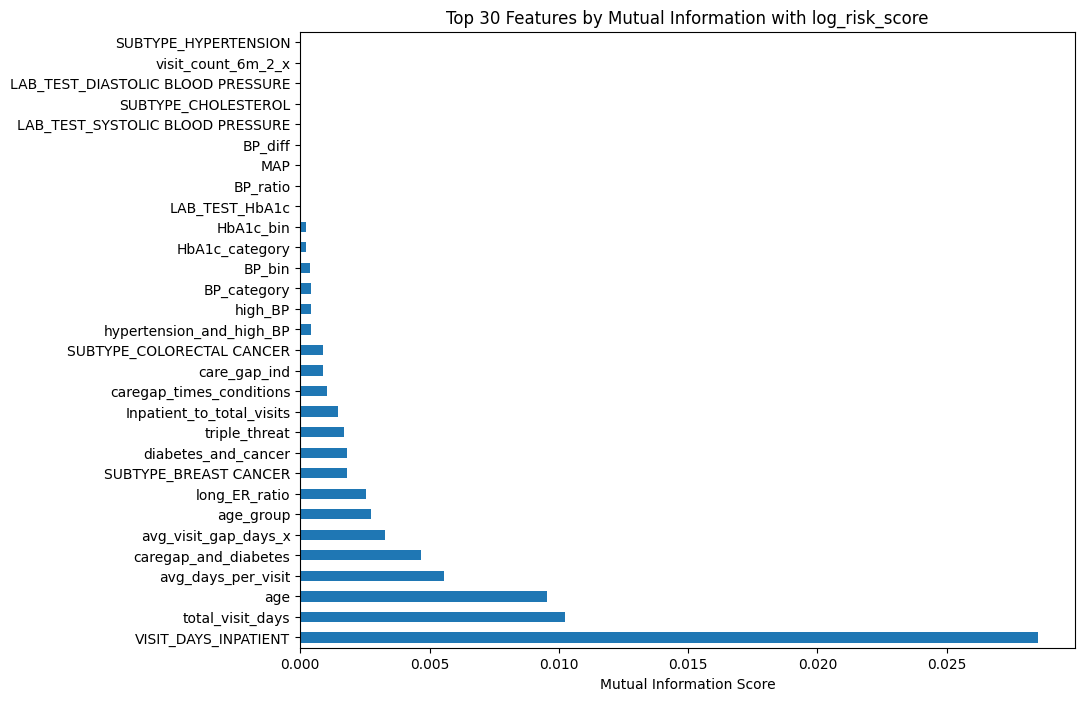

In [522]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


final_df_cleaned = final_df.copy()
# --- Prepare Data ---
# 1. Define your features (X) and target (y)
features_to_exclude = ['patient_id', 'risk_score', 'log_risk_score']
valid_features_to_exclude = [col for col in features_to_exclude if col in final_df_cleaned.columns]
X = final_df_cleaned.drop(columns=valid_features_to_exclude)
y = final_df_cleaned['log_risk_score']

# 2. Identify which features are discrete (for the MI algorithm)
# We'll do this *before* encoding them all to numbers
discrete_features = []
for col in X.columns:
    # Treat object types and low-cardinality numbers as discrete
    if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 20:
        discrete_features.append(True)
    else:
        discrete_features.append(False)

print(f"Identified {sum(discrete_features)} discrete features.")

# 3. Robustly handle NaNs and Encode all columns to be numeric
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]) and not discrete_features[X.columns.get_loc(col)]:
        # A) For continuous numeric columns: Fill with median (more robust to outliers than 0)
        X[col] = X[col].fillna(X[col].median())
    else:
        # B) For discrete, categorical, or object columns:

        # If it's already a category dtype, add 'Missing' as a valid category
        if pd.api.types.is_categorical_dtype(X[col]):
            if 'Missing' not in X[col].cat.categories:
                X[col] = X[col].cat.add_categories(['Missing'])

        # Fill NaNs (for object or category) with the 'Missing' string
        X[col] = X[col].fillna('Missing')

        # Now, convert the entire column to category codes (numbers)
        X[col] = pd.Categorical(X[col]).codes

# At this point, all columns in X are numeric (int or float) and have no NaNs.

# --- Calculate MI ---
print("Calculating Mutual Information scores...")
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)

# --- View Results ---
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("\n--- Mutual Information Scores (Feature vs. Target) ---")
print(mi_series)

# Plot the top 30
plt.figure(figsize=(10, 8))
mi_series.head(30).plot(kind='barh')
plt.title('Top 30 Features by Mutual Information with log_risk_score')
plt.xlabel('Mutual Information Score')
plt.show()

In [523]:
final_df_cleaned = final_df_cleaned[final_feature_columns]

KeyError: "['visit_count_6m_1', 'visit_count_6m_2', 'visit_count_6m_3', 'total_visit_count', 'avg_visit_gap_days', 'high_acuity_days', 'high_acuity_days_ratio'] not in index"

In [441]:
# # List of all columns to remove
# features_to_remove = [
#     # 1. Target Leakage & Identifiers
#     'risk_score',
#     'risk_tier',

#     # 2. Redundant Aggregates
#     'total_visits',
#     'total_visit_count',
#     'total_visit_days',
#     'high_acuity_visits',
#     'high_acuity_days',

#     # 3. Redundant Time-Series
#     'visit_count_6m_0',
#     'visit_count_6m_1',
#     'visit_count_6m_2',
#     'visit_count_6m_3',
#     'visit_count_6m_4',
#     'recent_visits',
#     'past_visits',
#     'recent_vs_past_diff',

#     # 4. Redundant Binned/Categorical
#     'age_group',
#     'HbA1c_bin',
#     'high_HbA1c',
#     'BP_bin',
#     'high_BP',

#     # 5. Redundant Engineered Labs
#     'LAB_TEST_SYSTOLIC BLOOD PRESSURE',
#     'LAB_TEST_DIASTOLIC BLOOD PRESSURE',
#     'BP_ratio'
# ]

# # Create the cleaned DataFrame
# # errors='ignore' will prevent an error if a column was already removed
# final_df_cleaned = final_df.drop(columns=features_to_remove, errors='ignore')

# # This is your final list of features for training (X)
# # You still need to separate your target variable (y)
# X_features_list = [col for col in final_df_cleaned.columns if col not in ['log_risk_score']]

# print(f"Original number of columns: {len(final_df.columns)}")
# print(f"Number of columns removed: {len(features_to_remove)}")
# print(f"Remaining columns (features + target): {len(final_df_cleaned.columns)}")
# print("\nFinal list of features to use for X:")
# print(X_features_list)

# # Now you can proceed with your train-test split
# # X = final_df_cleaned[X_features_list]
# # y = final_df_cleaned['log_risk_score']

In [442]:
%pip install catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Top 30 features by LightGBM importance: ['age', 'avg_visit_gap_days', 'age_and_ER_visits', 'age_times_num_conditions', 'weighted_visit_days', 'total_visit_days', 'age_times_diabetes', 'visit_volatility', 'high_acuity_days', 'visit_trend_slope', 'visit_count_6m_1', 'high_acuity_days_ratio', 'VISIT_DAYS_INPATIENT', 'high_acuity_ratio', 'COND_CANCER', 'avg_days_inpatient', 'avg_days_per_visit', 'visit_count_6m_0', 'SUBTYPE_COLORECTAL CANCER', 'Inpatient_to_total_visits', 'visit_type_diversity', 'ER_to_total_visits', 'long_ER_ratio', 'total_visit_count', 'high_acuity_visits', 'COND_HYPERTENSION', 'care_gap_ind', 'num_conditions', 'zero_visit_periods_count', 'LAB_TEST_HbA1c']


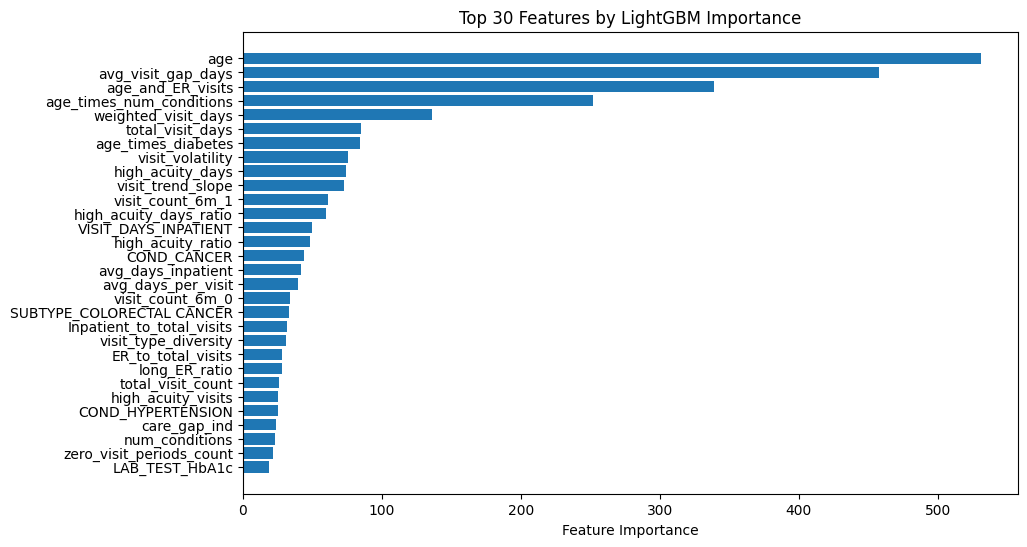

In [445]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select numeric features (excluding target)
X = final_df_cleaned.select_dtypes(include=['int64','float64']).drop(columns=['log_risk_score','patient_id', 'risk_score'])
y = final_df_cleaned['log_risk_score']

# Split into train/test (optional, for importance calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)

# Train a simple LightGBM regressor
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(params, lgb_train, num_boost_round=100)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
}).sort_values(by='importance', ascending=False)

# Select top k features
k = 30
top_features_lgb = feature_importance.head(k)['feature'].tolist()
print("Top", k, "features by LightGBM importance:", top_features_lgb)

# Optional: Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importance.head(k)['feature'], feature_importance.head(k)['importance'])
plt.xlabel('Feature Importance')
plt.title(f'Top {k} Features by LightGBM Importance')
plt.gca().invert_yaxis()
plt.show()


In [446]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 1. Prepare data
# -------------------------
X = final_df_cleaned[top_features_lgb]
y = final_df_cleaned['log_risk_score']  # target is log_risk_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 2a. Define models
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42)
}

# -------------------------
# 3. Train, predict and evaluate on original scale
# -------------------------
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict on log scale
    y_pred_log = model.predict(X_test)

    # Convert predictions back to original risk score scale
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 4. Compare all models
# -------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')
print("\nModel Comparison on Original Risk Score Scale:")
print(results_df)


LightGBM -> Original Scale RMSE: 1.5945, R2: 0.4476
XGBoost -> Original Scale RMSE: 1.5463, R2: 0.4805
CatBoost -> Original Scale RMSE: 1.4897, R2: 0.5178
RandomForest -> Original Scale RMSE: 1.5952, R2: 0.4471

Model Comparison on Original Risk Score Scale:
          Model      RMSE        R2
2      CatBoost  1.489722  0.517822
1       XGBoost  1.546348  0.480468
0      LightGBM  1.594535  0.447585
3  RandomForest  1.595182  0.447137


In [447]:
# --- Feature correlation matrix (numeric features only; excludes target) ---

import numpy as np
import pandas as pd

TARGET_COL = "risk_score"      # change if your target name differs
CORR_METHOD = "pearson"        # or "spearman"

# Copy and prep
df = final_df_cleaned.copy()

# Exclude target
X = df.drop(columns=[c for c in df.columns if c == TARGET_COL], errors="ignore")

# Treat booleans as ints and keep numeric columns
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)
work_num = X.select_dtypes(include=[np.number]).copy()

# Correlation matrix
corr = work_num.corr(method=CORR_METHOD)

# (Optional) upper triangle mask to avoid duplicates when listing pairs
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Preview
corr.head()  # or: display(corr)

,patient_id,LAB_TEST_HbA1c,LAB_TEST_SYSTOLIC BLOOD PRESSURE,LAB_TEST_DIASTOLIC BLOOD PRESSURE,SUBTYPE_BREAST CANCER,SUBTYPE_CHOLESTEROL,SUBTYPE_COLORECTAL CANCER,SUBTYPE_DIABETES,SUBTYPE_HYPERTENSION,care_gap_ind,...,recent_visits,past_visits,recent_vs_past_diff,visit_volatility,zero_visit_periods_count,high_acuity_visits,high_acuity_ratio,high_acuity_days,high_acuity_days_ratio,urgent_care_ratio
patient_id,1.000000,0.012352,0.001029,-0.005448,0.007842,-0.001217,-0.016519,0.000785,-0.022048,-0.007473,...,-0.010256,-0.008604,0.007204,-0.010391,0.010090,-0.002823,0.002031,0.002804,0.001064,-0.006311
LAB_TEST_HbA1c,0.012352,1.000000,-0.000522,-0.000404,-0.138362,-0.000516,-0.081367,-0.000421,-0.000596,0.130567,...,-0.001920,-0.013308,0.013106,-0.011518,0.016923,-0.006664,-0.003905,0.002880,-0.004069,-0.014165
LAB_TEST_SYSTOLIC BLOOD PRESSURE,0.001029,-0.000522,1.000000,-0.198415,-0.002216,-0.000380,-0.003642,-0.000310,-0.000438,0.096025,...,-0.001412,0.023899,-0.024219,0.015465,-0.015104,0.009364,-0.005245,0.005475,-0.003912,0.010631
LAB_TEST_DIASTOLIC BLOOD PRESSURE,-0.005448,-0.000404,-0.198415,1.000000,-0.001713,-0.000293,-0.002815,-0.000240,-0.000339,0.074228,...,-0.001092,-0.004465,0.004334,-0.004205,0.003186,-0.006118,-0.007629,-0.003465,-0.007676,0.005967
SUBTYPE_BREAST CANCER,0.007842,-0.138362,-0.002216,-0.001713,1.000000,0.113461,0.539980,-0.001788,0.047552,0.553962,...,0.004760,0.136255,-0.136279,0.124505,-0.102808,0.170568,0.099248,0.193997,0.104397,-0.001645


In [448]:
# --- List highly correlated pairs above a threshold ---

HIGH_CORR_THRESH = 0.8  # adjust as needed

# If 'upper' not defined from the previous block, compute it:
if "upper" not in globals():
    upper = work_num.corr(method=CORR_METHOD).where(
        np.triu(np.ones(work_num.shape[1]), k=1).astype(bool)
    )

high_pairs = (
    upper.stack()
         .rename("corr")
         .rename_axis(["feat1", "feat2"])
         .reset_index()
)
high_pairs["abs_corr"] = high_pairs["corr"].abs()
high_pairs = high_pairs.query("abs_corr >= @HIGH_CORR_THRESH") \
                       .sort_values("abs_corr", ascending=False) \
                       .reset_index(drop=True)

# Preview top pairs
high_pairs.head(30)  # or: display(high_pairs)


,feat1,feat2,corr,abs_corr
0,total_visit_count,total_visits,1.000000,1.000000
1,high_BP,hypertension_and_high_BP,1.000000,1.000000
2,high_HbA1c,caregap_and_high_HbA1c,1.000000,1.000000
3,COND_HYPERTENSION,hypertension_and_BP_diff,0.999628,0.999628
4,VISIT_COUNT_URGENT CARE,VISIT_DAYS_URGENT CARE,0.999603,0.999603
5,high_acuity_ratio,high_acuity_days_ratio,0.997413,0.997413
6,COND_DIABETES,HbA1c_times_diabetes,0.996741,0.996741
7,BP_ratio,BP_diff,0.995681,0.995681
8,visit_count_6m_3,recent_visits,0.990743,0.990743
9,VISIT_COUNT_ER,VISIT_DAYS_ER,0.990662,0.990662


In [449]:
# --- Drop a redundant feature from each high-corr pair
#     Keep the more predictive wrt target; else fewer NaNs; else higher variance ---

# y for predictiveness comparison; if missing, set y=None
y = df[TARGET_COL] if TARGET_COL in df.columns else None

def _choose_drop_feature(feat1, feat2, Xnum, yvec):
    s1, s2 = Xnum[feat1], Xnum[feat2]

    # (a) target predictiveness (absolute Pearson corr with target)
    if yvec is not None:
        yt = pd.to_numeric(yvec, errors="coerce")
        c1 = abs(pd.concat([s1, yt], axis=1).corr(method="pearson").iloc[0, 1])
        c2 = abs(pd.concat([s2, yt], axis=1).corr(method="pearson").iloc[0, 1])
        c1 = -1 if pd.isna(c1) else c1
        c2 = -1 if pd.isna(c2) else c2
        if c1 != c2:
            return feat2 if c1 > c2 else feat1  # drop the less predictive

    # (b) fewer NaNs
    n1, n2 = s1.isna().sum(), s2.isna().sum()
    if n1 != n2:
        return feat1 if n1 > n2 else feat2  # drop the one with MORE NaNs

    # (c) higher variance (keep higher variance; drop lower)
    v1, v2 = s1.var(skipna=True), s2.var(skipna=True)
    if not pd.isna(v1) and not pd.isna(v2) and v1 != v2:
        return feat2 if v1 > v2 else feat1

    # (d) tie-breaker: drop lexicographically later
    return max(feat1, feat2)

to_drop = []
seen_pairs = set()

for _, row in high_pairs.iterrows():
    f1, f2 = row["feat1"], row["feat2"]
    if f1 in to_drop or f2 in to_drop:
        continue
    key = tuple(sorted((f1, f2)))
    if key in seen_pairs:
        continue
    seen_pairs.add(key)
    drop_feat = _choose_drop_feature(f1, f2, work_num, y)
    to_drop.append(drop_feat)

# De-correlated feature set
X_decorrelated = work_num.drop(columns=to_drop, errors="ignore").copy()

# If you need target back:
final_for_model = (
    pd.concat([X_decorrelated, y], axis=1)
    if y is not None else X_decorrelated
)

# Quick summary
print("Dropped features due to high inter-feature correlation:", len(to_drop))
print(sorted(to_drop)[:50])
print("Original numeric features:", work_num.shape[1])
print("After dropping:", X_decorrelated.shape[1])


Dropped features due to high inter-feature correlation: 40
['BP_category', 'BP_ratio', 'COND_DIABETES', 'COND_HYPERTENSION', 'ER_to_total_visits', 'HbA1c_category', 'HbA1c_times_diabetes', 'LAB_TEST_DIASTOLIC BLOOD PRESSURE', 'MAP', 'VISIT_COUNT_ER', 'VISIT_COUNT_INPATIENT', 'VISIT_DAYS_ER', 'VISIT_DAYS_INPATIENT', 'VISIT_DAYS_URGENT CARE', 'age_and_ER_visits', 'age_times_diabetes', 'avg_days_ER', 'avg_days_inpatient', 'care_gap_ind', 'caregap_and_diabetes', 'high_BP', 'high_HbA1c', 'high_acuity_ratio', 'high_utilizer', 'hypertension_and_BP_diff', 'hypertension_and_high_BP', 'num_conditions', 'past_visits', 'recent_visits', 'recent_vs_past_diff', 'total_visit_days', 'total_visits', 'triple_threat', 'urgent_care_ratio', 'visit_count_6m_0', 'visit_trend_slope', 'visit_type_diversity', 'visit_volatility', 'weighted_visit_days', 'zero_visit_periods_count']
Original numeric features: 73
After dropping: 33


In [451]:
# Save final feature list
final_feature_columns = X_decorrelated.columns.tolist()


In [452]:
X_decorrelated=X_decorrelated.drop(columns='log_risk_score')

In [453]:
X_decorrelated

,patient_id,LAB_TEST_HbA1c,LAB_TEST_SYSTOLIC BLOOD PRESSURE,SUBTYPE_BREAST CANCER,SUBTYPE_CHOLESTEROL,SUBTYPE_COLORECTAL CANCER,SUBTYPE_DIABETES,SUBTYPE_HYPERTENSION,COND_CANCER,age,...,long_ER_ratio,caregap_times_conditions,diabetes_and_hypertension,diabetes_and_cancer,cancer_and_hypertension,caregap_and_high_HbA1c,caregap_and_high_utilizer,high_acuity_visits,high_acuity_days,high_acuity_days_ratio
0,1,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,5.7,120.0,0.0,0.0,0.0,0.0,0.0,1.0,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,46,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,82098,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,42,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
7996,82117,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7997,82120,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,82130,5.7,120.0,0.0,0.0,0.0,0.0,0.0,0.0,49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [308]:
from sklearn.impute import SimpleImputer
X = X_decorrelated.copy()
y = final_df_cleaned.loc[X.index, 'log_risk_score'].copy()

print(f"X shape: {X.shape} | y length: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Handle NaNs for sklearn RF (and to keep things consistent across models)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 2) Define models
# -------------------------
models = {
    # 'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    # 'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
    #                             max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    # 'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

# -------------------------
# 3) Train, predict, evaluate on ORIGINAL scale
# -------------------------
results = []

for name, model in models.items():
    # Train on imputed matrices (CatBoost/LightGBM/XGB handle NaNs, but we keep it uniform)
    model.fit(X_train_i, y_train)

    # Predict on log scale
    y_pred_log = model.predict(X_test_i)

    # Convert back to original risk score scale
    # If you used log1p for target, replace exp with expm1 for both y_pred and y_test.
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 4) Compare all models
# -------------------------
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale:")
print(results_df.to_string(index=False))


KeyError: '[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6411, 6412, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999] not in index'

In [329]:
from sklearn.impute import SimpleImputer
X = X_decorrelated.copy()
# y = final_df_cleaned.loc[X.index, 'log_risk_score'].copy()

In [331]:

# model.save_model("catboost_model.cbm")

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.load_model("catboost_model.cbm")

y_pred_log = model.predict(X)
y_pred = np.exp(y_pred_log)  # convert back to original scale

risk_output = pd.DataFrame({
    'patient_id': df['patient_id'],
    'predicted_risk_score': y_pred
})

risk_output.to_csv('risk.csv', index=False)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature 29 is present in model but not in pool.

In [104]:
%pip install sentence-transformers

# ==== 0) Imports & setup ====
import re
import numpy as np
import pandas as pd

# Embeddings
from sentence_transformers import SentenceTransformer

# Clustering
try:
    import hdbscan
    HAVE_HDBSCAN = True
except Exception:
    HAVE_HDBSCAN = False
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

# -----------------------------------------------------------
# 1) Normalize diagnosis strings (simple, robust text cleanup)
# -----------------------------------------------------------
def normalize_dx(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    # remove quotes/commas/brackets etc.
    s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
    # remove common filler words
    s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
    # drop laterality and basic stopwords that cause fragmentation
    s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
    # de-pluralize simple plurals (naive)
    s = re.sub(r"\b(\w+?)s\b", r"\1", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

visit_df = visit_df.copy()
visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# Keep a deduped vocabulary
dx_vocab = (
    visit_df.loc[visit_df["dx_norm"].str.len() > 0, "dx_norm"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Unique normalized diagnoses: {len(dx_vocab)}")

# -----------------------------------------
# 2) Embed the diagnosis vocabulary (SentBERT)
# -----------------------------------------
# Small, fast, surprisingly strong baseline model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(
    dx_vocab.tolist(),
    batch_size=256,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,  # cosine-ready
)
print("Embeddings shape:", emb.shape)

# ---------------------------------------------------
# 3) Cluster similar strings → cluster ids per term
#    Prefer HDBSCAN; fallback to Agglomerative
# ---------------------------------------------------
if HAVE_HDBSCAN:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,         # tune per dataset size
        min_samples=2,              # more/less conservative
        metric="euclidean",         # embeddings are normalized → euclidean ~ cosine
        cluster_selection_epsilon=0.05,
        cluster_selection_method="eom",
        prediction_data=False
    )
    labels = clusterer.fit_predict(emb)
else:
    # Agglomerative fallback with cosine distance threshold
    # Choose a threshold; smaller → more clusters, larger → fewer clusters
    D = pairwise_distances(emb, metric="cosine")
    # We set distance_threshold; n_clusters must be None for this mode
    clusterer = AgglomerativeClustering(
        n_clusters=None,
        affinity="precomputed",
        linkage="average",
        distance_threshold=0.1  # tune; ~cosine similarity 0.80
    )
    labels = clusterer.fit_predict(D)

# labels: -1 means "noise" in HDBSCAN; in Agglo everything gets a cluster
labels = pd.Series(labels, index=dx_vocab.index, name="dx_cluster")

# Map vocab → cluster
dx_map = pd.DataFrame({"dx_norm": dx_vocab, "dx_cluster": labels.values})

# Optional: pick a human-readable representative for each cluster
# (the most frequent original string in that cluster)
tmp = (
    visit_df.merge(dx_map, on="dx_norm", how="left")
            .groupby(["dx_cluster", "dx_norm"])
            .size()
            .rename("count")
            .reset_index()
)
rep = tmp.sort_values(["dx_cluster", "count"], ascending=[True, False]) \
         .drop_duplicates("dx_cluster") \
         .rename(columns={"dx_norm": "dx_representative"})[["dx_cluster", "dx_representative"]]

dx_map = dx_map.merge(rep, on="dx_cluster", how="left")

# Persist mapping if you want to inspect/edit:
# dx_map.to_csv("diagnosis_cluster_mapping.csv", index=False)

# ------------------------------------------------------
# 4) Attach clusters to visits and make per-patient features
# ------------------------------------------------------
vis = visit_df.merge(dx_map[["dx_norm", "dx_cluster"]], on="dx_norm", how="left")

# Put HDBSCAN noise into its own bucket (optional)
vis["dx_cluster"] = vis["dx_cluster"].fillna(-1).astype(int)

# Count visits per (patient, cluster)
dx_feat = (
    vis.groupby(["patient_id", "dx_cluster"])
       .size()
       .unstack(fill_value=0)
       .add_prefix("DXC_")
       .reset_index()
)

print("Diagnosis feature matrix shape (wide):", dx_feat.shape)

# ------------------------------------------------------
# 5) Join with your modeling feature matrix (X_decorrelated)
# ------------------------------------------------------
# Ensure patient_id is the index in both (or merge on column)
if "patient_id" not in X_decorrelated.index.names and "patient_id" in X_decorrelated.columns:
    X_base = X_decorrelated.set_index("patient_id")
else:
    X_base = X_decorrelated.copy()
    if "patient_id" not in X_base.index.names:
        raise ValueError("Please index X_decorrelated by patient_id or include a 'patient_id' column.")

dx_feat = dx_feat.set_index("patient_id")

# Align and fill missing
X_with_dx = X_base.join(dx_feat, how="left").fillna(0)

print("Original X_decorrelated:", X_base.shape)
print("X_with_dx:", X_with_dx.shape)

# If you keep only top-K clusters to control width:
K = 50  # tune
cluster_totals = dx_feat.sum(0).sort_values(ascending=False)
topk_cols = cluster_totals.index[:K]
X_with_dx_topk = X_base.join(dx_feat[topk_cols], how="left").fillna(0)
print("X_with_dx_topk:", X_with_dx_topk.shape)

# Optionally, keep both:
#   - X_with_dx (all clusters)
#   - X_with_dx_topk (top-K only)


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.7 MB/s  0:00:04a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 3.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.1 MB/s  0:00:01m 3.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.8 MB/s  0:00:003.7 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 5.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 3.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 16.4 MB/s  0:01:05 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 10.6 MB/s  0:00:43 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 6.4 MB/s  0:00:01 6.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.1 

Batches: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]

Embeddings shape: (1233, 384)


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [95]:
import re

def normalize_dx(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower().strip()
    # remove quotes/commas/brackets etc.
    s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
    # remove common filler words
    s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
    # drop laterality and basic stopwords that cause fragmentation
    s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
    # de-pluralize simple plurals (naive)
    s = re.sub(r"\b(\w+?)s\b", r"\1", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

visit_df = visit_df.copy()
visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# Keep a deduped vocabulary
dx_vocab = (
    visit_df.loc[visit_df["dx_norm"].str.len() > 0, "dx_norm"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Unique normalized diagnoses: {len(dx_vocab)}")


Unique normalized diagnoses: 1233


In [308]:
# # -------------------------
# # 1) Choose feature matrix
# # -------------------------
# if "X_with_dx_topk" in globals():
#     X = X_with_dx_topk.copy()
#     src = "X_with_dx_topk"
# elif "X_with_dx" in globals():
#     X = X_with_dx.copy()
#     src = "X_with_dx"
# else:
#     X = X_decorrelated.copy()
#     src = "X_decorrelated"

# # Ensure we can align by patient_id
# def ensure_index_by_patient_id(df):
#     if isinstance(df, pd.DataFrame):
#         if "patient_id" in df.index.names:
#             return df
#         if "patient_id" in df.columns:
#             return df.set_index("patient_id")
#     return df  # assume already indexed appropriately

# X = ensure_index_by_patient_id(X)
# ffc = final_df_cleaned.copy()
# ffc = ensure_index_by_patient_id(ffc)

# # Build y and align X,y on their common patient_ids
# y_all = ffc["log_risk_score"]
# common_idx = X.index.intersection(y_all.index)

# X = X.loc[common_idx].sort_index()
# y = y_all.loc[common_idx].sort_index()

# # Optional: drop rows with missing y
# mask = y.notna()
# X = X.loc[mask]
# y = y.loc[mask]

# print(f"Using features from: {src}")
# print(f"Aligned rows: {len(common_idx)} | After dropping NaN y: {mask.sum()}")
# print(f"X shape: {X.shape} | y length: {len(y)}")

# # -------------------------
# # 2) Train/test split & impute
# # -------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42
# )

# imp = SimpleImputer(strategy="median")
# X_train_i = imp.fit_transform(X_train)
# X_test_i  = imp.transform(X_test)

# # -------------------------
# # 3) Define models
# # -------------------------
# models = {
#     'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
#     'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
#                                 max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
#     'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
#     'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
# }

# # -------------------------
# # 4) Train, predict, evaluate on ORIGINAL scale
# # -------------------------
# results = []

# for name, model in models.items():
#     model.fit(X_train_i, y_train)
#     y_pred_log = model.predict(X_test_i)

#     # If target used log1p, replace exp with expm1 for both lines below
#     y_pred_orig = np.exp(y_pred_log)
#     y_test_orig = np.exp(y_test)

#     rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
#     r2 = r2_score(y_test_orig, y_pred_orig)

#     results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
#     print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# # -------------------------
# # 5) Compare all models
# # -------------------------
# results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
# print("\nModel Comparison on Original Risk Score Scale:")
# print(results_df.to_string(index=False))

In [91]:
%pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 2.1 MB/s  0:00:13a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]━━━━━━━━━━━ 2/3 [gensim]
Note: you may need to restart the kernel to use updated packages.


In [96]:
# --- Replace Step 2 (SentenceTransformer) with GloVe/word2vec embeddings via gensim ---

import re
import numpy as np
import pandas as pd
from collections import Counter
from gensim.utils import simple_preprocess
import gensim.downloader as api
from sklearn.preprocessing import normalize

# 1) Load a pre-trained word embedding model (pick ONE)
# Small & easy:
wv = api.load("glove-wiki-gigaword-100")        # 100-dim GloVe
# Alternative (bigger, slower, but strong):
# wv = api.load("word2vec-google-news-300")     # 300-dim word2vec (1.6GB)

dim = wv.vector_size

# 2) Tokenize normalized diagnoses (dx_vocab is from your previous step)
docs = [simple_preprocess(s, deacc=True, min_len=2) for s in dx_vocab.tolist()]

# 3) Build simple IDF from this corpus (for weighting)
N = len(docs)
df_counts = Counter()
for tokens in set(map(tuple, docs)):  # unique doc rows (optional)
    pass
# More precise DF: count once per document for each token
df_counts = Counter()
for tokens in docs:
    for t in set(tokens):
        df_counts[t] += 1

idf = {t: np.log((N + 1) / (df + 1)) + 1.0 for t, df in df_counts.items()}

# 4) Make IDF-weighted average embedding for each diagnosis
def sent_embed(tokens):
    vecs = []
    weights = []
    for t in tokens:
        if t in wv.key_to_index:         # known word
            vecs.append(wv.get_vector(t))
            weights.append(idf.get(t, 1.0))
    if not vecs:                         # all OOV → zero vector
        return np.zeros(dim, dtype=np.float32)
    V = np.vstack(vecs)
    w = np.asarray(weights, dtype=np.float32)[:, None]  # (k,1)
    return (V * w).sum(axis=0) / (w.sum() + 1e-9)

emb = np.vstack([sent_embed(tokens) for tokens in docs]).astype(np.float32)

# 5) L2-normalize (so cosine distance ≈ euclidean on the unit sphere)
emb = normalize(emb, norm="l2", axis=1)

print("Embeddings shape (GloVe/word2vec):", emb.shape)

# 6) Proceed with your existing clustering block unchanged
# (HDBSCAN with metric='euclidean' OR Agglomerative on cosine distances)
# Example (Agglomerative):
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

D = pairwise_distances(emb, metric="cosine")
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",   # use 'metric' (affinity is deprecated)
    linkage="average",
    distance_threshold=0.20  # tune: lower -> more clusters, higher -> fewer clusters
)
labels = clusterer.fit_predict(D)

Embeddings shape (GloVe/word2vec): (1233, 100)


In [97]:
# === Build X_with_dx and X_with_dx_topk from clustering labels ===
# Assumes you already have:
# - dx_vocab (list/Series of unique normalized diagnosis strings)
# - labels  (np.array of cluster ids aligned with dx_vocab)
# - visit_df with columns: patient_id, prncpl_diag_nm  (and optionally dx_norm)
# - X_decorrelated (patient-level features; has 'patient_id' as a column or index)

import re
import numpy as np
import pandas as pd

# 1) Ensure normalized text exists on visit_df (reuse your earlier normalize_dx if available)
try:
    normalize_dx
except NameError:
    def normalize_dx(s: str) -> str:
        if pd.isna(s): return ""
        s = s.lower().strip()
        s = re.sub(r"[\[\]\(\),;:\"'\/\\]+", " ", s)
        s = re.sub(r"\b(unspecified|other|initial encounter|without|with|and|type|region)\b", " ", s)
        s = re.sub(r"\b(left|right|bilateral|acute|chronic|primary|secondary)\b", " ", s)
        s = re.sub(r"\b(\w+?)s\b", r"\1", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

visit_df = visit_df.copy()
if "dx_norm" not in visit_df.columns:
    visit_df["dx_norm"] = visit_df["prncpl_diag_nm"].astype(str).map(normalize_dx)

# 2) Map vocab -> cluster id
dx_map = pd.DataFrame({
    "dx_norm": pd.Series(dx_vocab),
    "dx_cluster": pd.Series(labels).astype(int)
})

# (Optional) choose a human-readable representative per cluster
tmp = (
    visit_df.merge(dx_map, on="dx_norm", how="left")
            .groupby(["dx_cluster", "dx_norm"])
            .size()
            .rename("count")
            .reset_index()
)
rep = (tmp.sort_values(["dx_cluster","count"], ascending=[True, False])
          .drop_duplicates("dx_cluster")
          .rename(columns={"dx_norm":"dx_representative"})[["dx_cluster","dx_representative"]])
dx_map = dx_map.merge(rep, on="dx_cluster", how="left")

# 3) Attach clusters to visits
vis = visit_df.merge(dx_map[["dx_norm","dx_cluster"]], on="dx_norm", how="left")
# If your clustering produced noise labels (e.g., HDBSCAN -1), keep them or fill with -1
vis["dx_cluster"] = vis["dx_cluster"].fillna(-1).astype(int)

# 4) Pivot to per-patient cluster counts
dx_feat = (
    vis.groupby(["patient_id","dx_cluster"])
       .size()
       .unstack(fill_value=0)
       .add_prefix("DXC_")
       .reset_index()
)

# 5) Join with your base matrix X_decorrelated
if "patient_id" in getattr(X_decorrelated, "columns", []):
    X_base = X_decorrelated.set_index("patient_id").copy()
else:
    X_base = X_decorrelated.copy()
    if "patient_id" not in (X_base.index.names or []):
        raise ValueError("X_decorrelated must have 'patient_id' as a column or index.")

dx_feat = dx_feat.set_index("patient_id")
X_with_dx = X_base.join(dx_feat, how="left").fillna(0)

print("Original X_decorrelated:", X_base.shape)
print("X_with_dx:", X_with_dx.shape)

# 6) Build top-K cluster feature matrix (to control width)
K = 50  # tune this
cluster_totals = dx_feat.sum(axis=0).sort_values(ascending=False)
topk_cols = cluster_totals.index[:K]
X_with_dx_topk = X_base.join(dx_feat[topk_cols], how="left").fillna(0)

print("Top-K cluster columns:", (topk_cols))
print("X_with_dx_topk:", X_with_dx_topk.shape)


Original X_decorrelated: (8000, 31)
X_with_dx: (8000, 573)
Top-K cluster columns: Index(['DXC_38', 'DXC_36', 'DXC_13', 'DXC_307', 'DXC_79', 'DXC_275', 'DXC_85',
       'DXC_12', 'DXC_535', 'DXC_3', 'DXC_195', 'DXC_40', 'DXC_28', 'DXC_14',
       'DXC_21', 'DXC_92', 'DXC_124', 'DXC_423', 'DXC_6', 'DXC_76', 'DXC_30',
       'DXC_455', 'DXC_102', 'DXC_105', 'DXC_511', 'DXC_517', 'DXC_89',
       'DXC_271', 'DXC_235', 'DXC_48', 'DXC_299', 'DXC_94', 'DXC_503',
       'DXC_61', 'DXC_273', 'DXC_253', 'DXC_7', 'DXC_59', 'DXC_495', 'DXC_20',
       'DXC_401', 'DXC_492', 'DXC_374', 'DXC_197', 'DXC_18', 'DXC_122',
       'DXC_292', 'DXC_361', 'DXC_53', 'DXC_298'],
      dtype='object', name='dx_cluster')
X_with_dx_topk: (8000, 81)


In [98]:
# =========================
# Train & evaluate models after adding DX cluster features (robust alignment)
# =========================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 1) Choose feature matrix
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy()
    src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy()
    src = "X_with_dx"
else:
    X = X_decorrelated.copy()
    src = "X_decorrelated"

# Ensure we can align by patient_id
def ensure_index_by_patient_id(df):
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []):
            return df
        if "patient_id" in df.columns:
            return df.set_index("patient_id")
    return df  # assume already indexed appropriately

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Build y and align X,y on their common patient_ids
y_all = ffc["log_risk_score"]
common_idx = X.index.intersection(y_all.index)

X = X.loc[common_idx].sort_index()
y = y_all.loc[common_idx].sort_index()

# Optional: drop rows with missing y
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

print(f"Using features from: {src}")
print(f"Aligned rows: {len(common_idx)} | After dropping NaN y: {mask.sum()}")
print(f"X shape: {X.shape} | y length: {len(y)}")

# -------------------------
# 2) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 3) Define models
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

# -------------------------
# 4) Train, predict, evaluate on ORIGINAL scale
# -------------------------
results = []

for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # If target used log1p, replace exp with expm1 for both lines below
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 5) Compare all models
# -------------------------
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale:")
print(results_df.to_string(index=False))


Using features from: X_with_dx_topk
Aligned rows: 8000 | After dropping NaN y: 8000
X shape: (8000, 81) | y length: 8000


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> Original Scale RMSE: 1.5769, R2: 0.4598
XGBoost -> Original Scale RMSE: 1.5781, R2: 0.4589
CatBoost -> Original Scale RMSE: 1.5216, R2: 0.4970
RandomForest -> Original Scale RMSE: 1.5741, R2: 0.4617

Model Comparison on Original Risk Score Scale:
       Model     RMSE       R2
    CatBoost 1.521618 0.496953
RandomForest 1.574104 0.461651
    LightGBM 1.576874 0.459754
     XGBoost 1.578146 0.458883


In [101]:
# ==============================
# SHAP analysis on trained model
# Drop 10 least important features
# ==============================
%pip install shap
import numpy as np
import pandas as pd
import shap

# --- 0) Choose which trained model to explain ---
# Use one of: 'LightGBM', 'XGBoost', 'CatBoost', 'RandomForest'
MODEL_NAME = 'LightGBM'

# Refit the chosen model on the imputed training data (keeps things explicit/reproducible)
model = models[MODEL_NAME]
model.fit(X_train_i, y_train)

# --- 1) Build DataFrames after imputation so SHAP has feature names ---
X_train_i_df = pd.DataFrame(X_train_i, columns=X.columns, index=X_train.index)
X_test_i_df  = pd.DataFrame(X_test_i,  columns=X.columns, index=X_test.index)

# --- 2) Compute SHAP values ---
# TreeExplainer works for tree-based models (LGBM/XGB/CatBoost/RF)
explainer = shap.TreeExplainer(model)
# For regression, shap_values is (n_samples, n_features)
shap_values = explainer.shap_values(X_test_i_df)

# Ensure we have the right shape if library returns list (older CatBoost/XGB versions)
if isinstance(shap_values, list):
    # pick the single output for regression
    shap_values = shap_values[0]

# --- 3) Mean |SHAP| per feature (global importance) ---
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_test_i_df.columns).sort_values(ascending=False)

print("\nTop 15 features by mean |SHAP|:")
print(shap_importance.head(15).to_string())

print("\nBottom 15 features by mean |SHAP|:")
print(shap_importance.tail(15).to_string())

# --- 4) Pick the 10 least important features & drop them from the full X ---
bottom_10 = shap_importance.tail(10).index.tolist()
print("\nWill drop these 10 lowest-importance features:")
print(bottom_10)

X_shap_reduced = X.drop(columns=bottom_10, errors="ignore").copy()
print(f"\nOriginal feature count: {X.shape[1]} -> After drop: {X_shap_reduced.shape[1]}")

# If you want to continue training with reduced features:
# Re-split using the same indices to keep comparability
X_train_r = X_shap_reduced.loc[X_train.index]
X_test_r  = X_shap_reduced.loc[X_test.index]

# Re-impute (since columns changed)
from sklearn.impute import SimpleImputer
imp_r = SimpleImputer(strategy="median")
X_train_r_i = imp_r.fit_transform(X_train_r)
X_test_r_i  = imp_r.transform(X_test_r)

# (Optional) quick re-eval with the same model
model_r = models[MODEL_NAME]
model_r.fit(X_train_r_i, y_train)
y_pred_log_r = model_r.predict(X_test_r_i)

# If target was log1p, replace exp by expm1
y_pred_orig_r = np.exp(y_pred_log_r)
y_test_orig   = np.exp(y_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_r = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig_r))
r2_r   = r2_score(y_test_orig, y_pred_orig_r)
print(f"\n[{MODEL_NAME} after dropping 10 features] -> RMSE: {rmse_r:.4f}, R2: {r2_r:.4f}")

# --- (Optional) SHAP plots ---
shap.summary_plot(shap_values, X_test_i_df, plot_type="bar", max_display=30)
shap.summary_plot(shap_values, X_test_i_df, max_display=30)


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.0 MB/s  0:00:00m 5.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.4 MB/s  0:00:002.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s  0:00:04 eta 0:00:010:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]━━━━━━ 5/6 [shap] [numba]
Note: you may need to restart the kernel to use updated packages.


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Shape of passed values is (6400, 58), indices imply (6400, 81)

In [99]:
# ============================================================
# WOE/IV-based feature selection + correlation pruning + train
# ============================================================
# Uses:
#   - X_with_dx_topk (preferred) or X_with_dx or X_decorrelated
#   - final_df_cleaned['log_risk_score'] (regression target)
# Steps:
#   1) Align X with y; derive binary label for WOE/IV from original risk score (median split)
#   2) Compute IV for each feature (numeric & categorical)
#   3) Drop N lowest-IV features
#   4) Prune redundant features via high inter-feature correlation (|r| >= THRESH), keeping higher-IV one
#   5) Train models (LGBM/XGB/CatBoost/RF) on remaining features; score on ORIGINAL scale
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 0) Choose feature matrix
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy(); src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy(); src = "X_with_dx"
else:
    X = X_decorrelated.copy(); src = "X_decorrelated"

def ensure_index_by_patient_id(df):
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []): return df
        if "patient_id" in df.columns: return df.set_index("patient_id")
    return df

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Align
y_log = ffc["log_risk_score"]
common_idx = X.index.intersection(y_log.index)
X = X.loc[common_idx].sort_index()
y_log = y_log.loc[common_idx].sort_index()

# Build ORIGINAL-scale target for eval & a BINARY label for WOE/IV
y_orig = np.exp(y_log)            # if you used log1p, switch to np.expm1
thr = y_orig.median()             # binary split threshold (median). Change to .quantile(0.75) if desired
y_bin = (y_orig >= thr).astype(int)

print(f"[INFO] Using {src} | X: {X.shape} | y_orig: {y_orig.shape} | Positive rate: {y_bin.mean():.3f}")

# -------------------------
# 1) WOE/IV utilities
# -------------------------
EPS = 1e-9

def _woe_iv_from_counts(evt, nevt):
    """evt/nevt are arrays of event/non-event counts per bin/category."""
    evt = np.asarray(evt, dtype=float)
    nevt = np.asarray(nevt, dtype=float)
    total_evt = evt.sum(); total_nevt = nevt.sum()
    if total_evt == 0 or total_nevt == 0:
        # degenerate case: return zeros to avoid nuking all features
        return np.zeros_like(evt), 0.0
    p_evt = evt / total_evt + EPS
    p_nevt = nevt / total_nevt + EPS
    woe = np.log(p_evt / p_nevt)
    iv = ((p_evt - p_nevt) * woe).sum()
    return woe, float(iv)

def iv_for_series(x, y_bin, max_bins=10):
    """Compute IV for a single feature x against binary label y_bin.
       Numeric → quantile binning; Categorical → category grouping (top 50 cats, rest='__OTHER__')."""
    s = pd.Series(x)
    # Handle all-NaN or constant
    if s.dropna().nunique() <= 1:
        return 0.0

    if pd.api.types.is_numeric_dtype(s):
        # Quantile bins with fallbacks if not enough unique values
        try:
            # deduplicate edges
            q = np.linspace(0, 1, num=max_bins+1)
            bins = pd.qcut(s, q=q, duplicates="drop")
        except Exception:
            # fallback: uniform bins
            try:
                bins = pd.cut(s, bins=min(max_bins, int(s.nunique())))
            except Exception:
                return 0.0
        grp = pd.DataFrame({"bin": bins, "y": y_bin}).dropna(subset=["bin"])
        ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

    else:
        # Categorical: cap high cardinality
        vc = s.astype(str).value_counts(dropna=False)
        top = set(vc.index[:50])  # cap to top 50 categories
        cat = s.astype(str).where(s.astype(str).isin(top), "__OTHER__")
        grp = pd.DataFrame({"cat": cat, "y": y_bin}).dropna(subset=["cat"])
        ct = grp.groupby("cat")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

# -------------------------
# 2) Compute IV for all features
# -------------------------
iv_scores = {}
for col in X.columns:
    try:
        iv_scores[col] = iv_for_series(X[col], y_bin, max_bins=10)
    except Exception:
        iv_scores[col] = 0.0

iv_series = pd.Series(iv_scores).sort_values(ascending=False)
print("\n[INFO] Top 15 IV features:")
print(iv_series.head(15).to_string())
print("\n[INFO] Bottom 15 IV features:")
print(iv_series.tail(15).to_string())

# -------------------------
# 3) Drop N lowest-IV features
# -------------------------
N_DROP = 15  # change as needed
lowest_features = iv_series.tail(N_DROP).index.tolist()
print(f"\n[INFO] Dropping {N_DROP} lowest-IV features:")
print(lowest_features)
X_iv = X.drop(columns=lowest_features, errors="ignore")

# -------------------------
# 4) Correlation pruning among remaining numeric features
#    - compute Pearson on numeric cols
#    - for each pair with |r| >= THRESH, drop the one with LOWER IV
# -------------------------
THRESH = 0.7
num_df = X_iv.select_dtypes(include=[np.number]).copy()

if num_df.shape[1] >= 2:
    corr = num_df.corr(method="pearson")
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    high_pairs = (
        upper.stack()
             .rename("corr")
             .rename_axis(["f1","f2"])
             .reset_index()
    )
    high_pairs["abs_corr"] = high_pairs["corr"].abs()
    high_pairs = high_pairs.query("abs_corr >= @THRESH").sort_values("abs_corr", ascending=False)

    to_drop_corr = []
    kept = set(X_iv.columns)
    for _, row in high_pairs.iterrows():
        f1, f2 = row["f1"], row["f2"]
        # skip if either already dropped
        if f1 not in kept or f2 not in kept:
            continue
        iv1 = iv_series.get(f1, 0.0)
        iv2 = iv_series.get(f2, 0.0)
        # keep higher-IV, drop lower-IV
        if iv1 >= iv2:
            drop_feat = f2
        else:
            drop_feat = f1
        to_drop_corr.append(drop_feat)
        kept.remove(drop_feat)

    print(f"\n[INFO] Correlation pruning: dropping {len(to_drop_corr)} redundant features (|r| >= {THRESH})")
    X_final = X_iv.drop(columns=to_drop_corr, errors="ignore")
else:
    print("\n[INFO] Skipped correlation pruning (not enough numeric features).")
    X_final = X_iv.copy()

print(f"[INFO] Feature count: original {X.shape[1]} -> after IV drop {X_iv.shape[1]} -> after corr prune {X_final.shape[1]}")

# -------------------------
# 5) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log.loc[X_final.index], test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 6) Define & train models; evaluate on ORIGINAL scale
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # If you used log1p for target, change to np.expm1
    y_pred_orig = np.exp(y_pred_log)
    y_test_orig = np.exp(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results.append({"Model": name, "RMSE": rmse, "R2": r2})
    print(f"{name} -> Original Scale RMSE: {rmse:.4f}, R2: {r2:.4f}")

results_df = pd.DataFrame(results).sort_values(by="RMSE").reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):")
print(results_df.to_string(index=False))


[INFO] Using X_with_dx_topk | X: (8000, 81) | y_orig: (8000,) | Positive rate: 0.502

[INFO] Top 15 IV features:
age                                 1.325616
age_times_num_conditions            1.084887
high_acuity_days_ratio              0.157340
high_acuity_days                    0.154150
high_acuity_visits                  0.133092
total_visit_count                   0.122858
avg_days_per_visit                  0.094155
avg_visit_gap_days                  0.055426
LAB_TEST_HbA1c                      0.025652
VISIT_COUNT_URGENT CARE             0.015548
LAB_TEST_SYSTOLIC BLOOD PRESSURE    0.001594
BP_diff                             0.001594
avg_days_urgent                     0.000170
COND_CANCER                         0.000000
SUBTYPE_HYPERTENSION                0.000000

[INFO] Bottom 15 IV features:
DXC_253    0.0
DXC_7      0.0
DXC_59     0.0
DXC_495    0.0
DXC_20     0.0
DXC_401    0.0
DXC_492    0.0
DXC_374    0.0
DXC_197    0.0
DXC_18     0.0
DXC_122    0.0
DXC_292    0.0
D

/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/2881343706.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = grp.groupby("bin")["y"].agg(evt="sum", cnt="count"


[INFO] Correlation pruning: dropping 8 redundant features (|r| >= 0.7)
[INFO] Feature count: original 81 -> after IV drop 66 -> after corr prune 58


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> Original Scale RMSE: 1.6326, R2: 0.4209
XGBoost -> Original Scale RMSE: 1.6764, R2: 0.3894
CatBoost -> Original Scale RMSE: 1.5474, R2: 0.4797
RandomForest -> Original Scale RMSE: 1.6414, R2: 0.4147

Model Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):
       Model     RMSE       R2
    CatBoost 1.547429 0.479742
    LightGBM 1.632631 0.420874
RandomForest 1.641358 0.414666
     XGBoost 1.676439 0.389377


In [100]:
# ============================================================
# WOE/IV feature selection + correlation pruning + train/eval (with MAE)
# Works with X_with_dx_topk / X_with_dx / X_decorrelated and final_df_cleaned['log_risk_score']
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# 0) Choose feature matrix & align by patient_id
# -------------------------
if "X_with_dx_topk" in globals():
    X = X_with_dx_topk.copy(); src = "X_with_dx_topk"
elif "X_with_dx" in globals():
    X = X_with_dx.copy(); src = "X_with_dx"
else:
    X = X_decorrelated.copy(); src = "X_decorrelated"

def ensure_index_by_patient_id(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df, pd.DataFrame):
        if "patient_id" in (df.index.names or []):
            return df
        if "patient_id" in df.columns:
            return df.set_index("patient_id")
    return df

X = ensure_index_by_patient_id(X)
ffc = ensure_index_by_patient_id(final_df_cleaned.copy())

# Targets
y_log = ffc["log_risk_score"]
common_idx = X.index.intersection(y_log.index)
X = X.loc[common_idx].sort_index()
y_log = y_log.loc[common_idx].sort_index()

# Original-scale target for metrics, and binary target for WOE/IV
y_orig = np.exp(y_log)           # if you used log1p earlier, switch to: np.expm1(y_log)
y_bin = (y_orig >= y_orig.median()).astype(int)

print(f"[INFO] Source: {src} | X: {X.shape} | Pos rate (WOE/IV label): {y_bin.mean():.3f}")

# -------------------------
# 1) WOE/IV helpers
# -------------------------
EPS = 1e-9

def _woe_iv_from_counts(evt, nevt):
    evt = np.asarray(evt, dtype=float)
    nevt = np.asarray(nevt, dtype=float)
    tot_e, tot_ne = evt.sum(), nevt.sum()
    if tot_e <= 0 or tot_ne <= 0:
        return np.zeros_like(evt), 0.0
    p_e = evt / tot_e + EPS
    p_ne = nevt / tot_ne + EPS
    woe = np.log(p_e / p_ne)
    iv = float(((p_e - p_ne) * woe).sum())
    return woe, iv

def iv_for_series(x: pd.Series, yb: pd.Series, max_bins: int = 10) -> float:
    s = pd.Series(x)
    # constant or all-NaN
    if s.dropna().nunique() <= 1:
        return 0.0

    if pd.api.types.is_numeric_dtype(s):
        # quantile binning
        try:
            bins = pd.qcut(s, q=np.linspace(0, 1, max_bins + 1), duplicates="drop")
        except Exception:
            # fallback to uniform binning
            try:
                bins = pd.cut(s, bins=min(max_bins, int(s.dropna().nunique())))
            except Exception:
                return 0.0
        dfb = pd.DataFrame({"bin": bins, "y": yb}).dropna(subset=["bin"])
        ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv
    else:
        # categorical: cap high cardinality
        vc = s.astype(str).value_counts(dropna=False)
        top = set(vc.index[:50])
        cat = s.astype(str).where(s.astype(str).isin(top), "__OTHER__")
        dfb = pd.DataFrame({"cat": cat, "y": yb}).dropna(subset=["cat"])
        ct = dfb.groupby("cat")["y"].agg(evt="sum", cnt="count")
        ct["nevt"] = ct["cnt"] - ct["evt"]
        _, iv = _woe_iv_from_counts(ct["evt"].values, ct["nevt"].values)
        return iv

# -------------------------
# 2) Compute IV for all features
# -------------------------
iv_scores = {}
for col in X.columns:
    try:
        iv_scores[col] = iv_for_series(X[col], y_bin, max_bins=10)
    except Exception:
        iv_scores[col] = 0.0

iv_series = pd.Series(iv_scores).sort_values(ascending=False)
print("\n[INFO] Top 12 IV features:")
print(iv_series.head(12).to_string())
print("\n[INFO] Bottom 12 IV features:")
print(iv_series.tail(12).to_string())

# -------------------------
# 3) Drop lowest-IV features
# -------------------------
N_DROP = 15  # drop 10 lowest-IV as requested
to_drop_iv = iv_series.tail(N_DROP).index.tolist()
print(f"\n[INFO] Dropping {N_DROP} lowest-IV features:\n{to_drop_iv}")
X_iv = X.drop(columns=to_drop_iv, errors="ignore")

# -------------------------
# 4) Correlation pruning (among numeric), keep higher-IV
# -------------------------
THRESH = 0.7  # |corr| threshold

num_df = X_iv.select_dtypes(include=[np.number])
to_drop_corr = []

if num_df.shape[1] >= 2:
    corr = num_df.corr(method="pearson")
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
             .rename("corr")
             .rename_axis(["f1", "f2"])
             .reset_index()
    )
    pairs["abs_corr"] = pairs["corr"].abs()
    high_pairs = pairs.query("abs_corr >= @THRESH").sort_values("abs_corr", ascending=False)

    kept = set(X_iv.columns)
    for _, row in high_pairs.iterrows():
        f1, f2 = row["f1"], row["f2"]
        if f1 not in kept or f2 not in kept:
            continue
        iv1 = iv_series.get(f1, 0.0)
        iv2 = iv_series.get(f2, 0.0)
        drop_feat = f2 if iv1 >= iv2 else f1
        to_drop_corr.append(drop_feat)
        kept.remove(drop_feat)

    X_final = X_iv.drop(columns=to_drop_corr, errors="ignore")
    print(f"\n[INFO] Correlation pruning dropped {len(to_drop_corr)} features (|r| >= {THRESH}):\n{sorted(set(to_drop_corr))}")
else:
    X_final = X_iv.copy()
    print("\n[INFO] Skipped correlation pruning (not enough numeric features).")

print(f"\n[INFO] Feature counts -> original: {X.shape[1]} | after IV: {X_iv.shape[1]} | after corr: {X_final.shape[1]}")

# -------------------------
# 5) Train/test split & impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log.loc[X_final.index], test_size=0.20, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# -------------------------
# 6) Define, train, evaluate (MAE, RMSE, R2 on ORIGINAL scale)
# -------------------------
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', n_estimators=500, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                max_depth=6, subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, loss_function='RMSE', verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    model.fit(X_train_i, y_train)
    y_pred_log = model.predict(X_test_i)

    # Back-transform to original scale
    y_pred_orig = np.exp(y_pred_log)   # if log1p was used to create y, switch to np.expm1
    y_test_orig = np.exp(y_test)

    mae  = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2   = r2_score(y_test_orig, y_pred_orig)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    print(f"{name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
print("\nModel Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):")
print(results_df.to_string(index=False))


[INFO] Source: X_with_dx_topk | X: (8000, 81) | Pos rate (WOE/IV label): 0.502

[INFO] Top 12 IV features:
age                                 1.325616
age_times_num_conditions            1.084887
high_acuity_days_ratio              0.157340
high_acuity_days                    0.154150
high_acuity_visits                  0.133092
total_visit_count                   0.122858
avg_days_per_visit                  0.094155
avg_visit_gap_days                  0.055426
LAB_TEST_HbA1c                      0.025652
VISIT_COUNT_URGENT CARE             0.015548
LAB_TEST_SYSTOLIC BLOOD PRESSURE    0.001594
BP_diff                             0.001594

[INFO] Bottom 12 IV features:
DXC_495    0.0
DXC_20     0.0
DXC_401    0.0
DXC_492    0.0
DXC_374    0.0
DXC_197    0.0
DXC_18     0.0
DXC_122    0.0
DXC_292    0.0
DXC_361    0.0
DXC_53     0.0
DXC_298    0.0

[INFO] Dropping 15 lowest-IV features:
['DXC_253', 'DXC_7', 'DXC_59', 'DXC_495', 'DXC_20', 'DXC_401', 'DXC_492', 'DXC_374', 'DXC_197', 'DXC_1

/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/tmp/ipykernel_28417/566809289.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct = dfb.groupby("bin")["y"].agg(evt="sum", cnt="count")
/


[INFO] Correlation pruning dropped 8 features (|r| >= 0.7):
['BP_diff', 'VISIT_COUNT_URGENT CARE', 'avg_days_per_visit', 'caregap_and_high_utilizer', 'caregap_times_conditions', 'diabetes_and_hypertension', 'high_acuity_visits', 'visit_count_6m_1']

[INFO] Feature counts -> original: 81 | after IV: 66 | after corr: 58


/home/nikhil/hilabs/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM -> MAE: 0.7873 | RMSE: 1.6326 | R2: 0.4209
XGBoost -> MAE: 0.7805 | RMSE: 1.6764 | R2: 0.3894
CatBoost -> MAE: 0.7608 | RMSE: 1.5474 | R2: 0.4797
RandomForest -> MAE: 0.7972 | RMSE: 1.6414 | R2: 0.4147

Model Comparison on Original Risk Score Scale (after WOE/IV + Corr prune):
       Model      MAE     RMSE       R2
    CatBoost 0.760831 1.547429 0.479742
     XGBoost 0.780497 1.676439 0.389377
    LightGBM 0.787261 1.632631 0.420874
RandomForest 0.797195 1.641358 0.414666
